<font size="6">ExoNet Project 1 CV Research Code</font>



<font size="4">Current Task</font>



<font size="5">Import PyTorch and other Packages</font>

- change kernel to pytorch 3.8 (issue with other versions not having a read_file function

In [1]:
# from oauth2client.client import GoogleCredentials
# import PyTorch
# ! pip install pytorch==1.8.1
import os
import sys
# py_dll_path = os.path.join(sys.exec_prefix, 'Library', 'bin')
# os.environ['PATH'] += py_dll_path

# ! pip install torch==1.9.0
# ! pip install torchvision==0.10.0

import torch

#cuda checklist
torch.cuda.is_available()
torch.cuda.current_device()
print(torch.cuda.get_device_name(0))
torch.cuda.memory_allocated()
torch.cuda.memory_cached()
print(torch.__version__)

import torchvision
print(torchvision.__version__)
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

%config Completer.use_jedi = False

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive

import unittest
import subprocess
import numpy as np
from torch import nn
from tqdm import tqdm
# from zipfile import ZipFile
from PIL import Image
from typing import Optional, Callable
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

NVIDIA GeForce RTX 3070
1.10.1
0.11.2


C:\Users\akurb\anaconda3\envs\CV_Research_Run\lib\site-packages\torch\cuda\memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


<font size="5">Dataset File Download and Preparation</font>



Import Project 1 Dataset zip file from Azure Dataset CloudStorage (Comment out for test)

In [2]:
# # azureml-core of version 1.0.72 or higher is required
# from azureml.core import Workspace, Dataset

# subscription_id = '7cb1905b-a1d4-4279-ab8b-8849b50ad375'
# resource_group = 'Project-UofT'
# workspace_name = 'CV_Research_UofT'

# workspace = Workspace(subscription_id, resource_group, workspace_name)

# dataset = Dataset.get_by_name(workspace, name='ExoNet_Project1_Test')

# if not os.path.exists('ExoNet_Project1_Test.zip'):
#     dataset.download(target_path='.', overwrite=False)


Unzip Project 1 Dataset

In [3]:
# if not os.path.exists('Project1_Sorted_Dataset'):
#     ! unzip Project1_Sorted_Dataset.zip 

Import zip Project 1 Test zip file from Azure Dataset CloudStorage (Comment out for large data run)

In [4]:
# if not os.path.exists('ExoNet_Project1_Test3.zip'):
#     # azureml-core of version 1.0.72 or higher is required
#     from azureml.core import Workspace, Dataset

#     subscription_id = 'a5115b00-792f-44a5-b5fd-7f65d3a2f0c6'
#     resource_group = 'cv_research'
#     workspace_name = 'cv_research_project1'

#     workspace = Workspace(subscription_id, resource_group, workspace_name)

#     dataset = Dataset.get_by_name(workspace, name='ExoNet_Project1_Test')
#     dataset.download(target_path='.', overwrite=False)

Unzip Test Dataset

In [5]:
# if not os.path.exists('ExoNet_Project1_Test2'):
#     ! unzip ExoNet_Project1_Test3.zip 

<font size="5">Setting up Database for model training</font>



ExoNet Dataset class definition
To do: 
- random sample to 224

In [6]:
class ExoNetDataset(ImageFolder):

    def __init__(self, root: str = ".", download: bool = False, mode: str = "train", shape: int = 256, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, show: bool = True):
        tag = "ExoNetDataset"

        modes = ["train", "val", "test"]
        assert mode in modes, "Available options for mode: train, val, test"

        self.shape = shape
        self.mode = mode
        # if download:
        #     download_datasets(tag, path=root)
        #     extract_zip(os.path.join(root, tag+".zip"),
        #                 os.path.join(root, tag))

        if transform is None:
            self.transform = self.default_transform(mode)
        else:
            self.transform = transform

        if target_transform is not None:
            self.target_transform = target_transform

        if download:
            dataset_path = os.path.join(root, tag, "ExoNet", mode)
        else:
            dataset_path = os.path.join(root, mode)

        super(ExoNetDataset, self).__init__(
            root=dataset_path, transform=self.transform)

        if show:
            self.visualize_batch()

    def __getitem__(self, index):
        path, target = self.samples[index]
        fname = path.split("/")[-1]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
#         print(img, target, fname)
        return img, target, fname

    def default_transform(self, mode="train"):
        if mode == "train":
            transform = transforms.Compose([
                transforms.Resize((self.shape, self.shape)),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
            ])

        elif mode == 'val' or mode == 'test':
            transform = transforms.Compose([
                transforms.Resize((self.shape, self.shape)),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
            ])

        return transform

    def visualize_batch(self):
        loader = DataLoader(self, batch_size=4, shuffle=True)
        inputs, labels, fnames = next(iter(loader))
        list_imgs = [inputs[i] for i in range(len(inputs))]

        self.show(list_imgs, labels, fnames)

    def show(self, imgs, labels, fnames):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):

            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * img + mean
            inp = np.clip(inp, 0, 1)

            axs[0, i].imshow(np.asarray(inp))
            axs[0, i].set(xticks=[], yticks=[])
            axs[0, i].text(0, -0.2, str(int(labels[i])) + ": " +
                           self.classes[labels[i]], transform=axs[0, i].transAxes)
            axs[0, i].set_title("..."+fnames[i][-12:-5])

<font size="5">Creating Custom Datasets</font>



Functionality Test Dataset for Testing Code

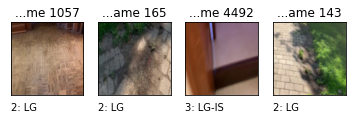

In [7]:
test_path = r"D:\UofT_Project\ExoNet_Project1_Test2"

func_train_dataset = ExoNetDataset(root=test_path, download=False, mode="train", show=True)
func_valid_dataset = ExoNetDataset(root=test_path, download=False, mode="val", show=False)
func_test_dataset = ExoNetDataset(root=test_path, download=False, mode="test", show=False)

In [8]:
func_train_loader = DataLoader(func_train_dataset, batch_size=16, shuffle=True, pin_memory=True)
func_valid_loader = DataLoader(func_valid_dataset, batch_size=8, shuffle=True, pin_memory=True)
func_test_loader = DataLoader(func_test_dataset, batch_size=8, shuffle=True, pin_memory=True)

ExoNet Project 1 Complete Sorted/Randomized Dataset
- set batch size to hyperparameter findings before running

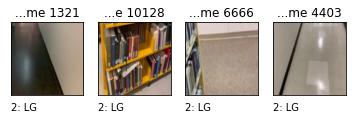

In [9]:
_path = "D:\Project1_Sorted_Dataset"

test_path = r"D:\UofT_Project\ExoNet_Project1_Test2"

train_dataset = ExoNetDataset(root=_path, download=False, mode="train", show=True)
valid_dataset = ExoNetDataset(root=_path, download=False, mode="val", show=False)
test_dataset = ExoNetDataset(root=_path, download=False, mode="test", show=False)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, pin_memory=True)
test_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, pin_memory=True)

ExoNet Project 1 Subsets for Hyperparameter Optimization
- set batch size before running 

In [11]:
# #10% subset
# part_train_dataset = torch.utils.data.random_split(train_dataset, [48586, len(train_dataset)-48586])[0]
# part_valid_dataset = torch.utils.data.random_split(valid_dataset, [1900, len(valid_dataset)-1900])[0]

#25% subset
part_train_dataset = torch.utils.data.random_split(train_dataset, [121467, len(train_dataset)-121467])[0]
part_valid_dataset = torch.utils.data.random_split(valid_dataset, [4750, len(valid_dataset)-4750])[0]

# #50% subset
# part_train_dataset = torch.utils.data.random_split(train_dataset, [242933, len(train_dataset)-242933])[0]
# part_valid_dataset = torch.utils.data.random_split(valid_dataset, [9500, len(valid_dataset)-9500])[0]

In [12]:
# batch_size_list = [32, 64, 128, 256]

part_train_loader = DataLoader(part_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
part_valid_loader = DataLoader(part_valid_dataset, batch_size=32, shuffle=True, pin_memory=True)

<font size="5">Call model and set parameters</font>



The following calls the model from torchvision models which has a default initialization of the weights to zeros
- to initialize the weights between hyperparameter testing call this function

In [13]:
#model initialization
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model = torchvision.models.mobilenet_v2(pretrained=False)
model.__init__
gpumodel = model.cuda()
print("model is ready!")
            
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)


model is ready!


Make sure gpumodel is loading corrently on the gpu (should output true)

In [14]:
next(gpumodel.parameters()).is_cuda

True

Loop definitions

In [15]:
def train_and_val_loop(dataloader, datavalid_loader, gpumodel, loss_fn, optimizer, model_name, min_val_loss):
    
    size = len(dataloader.dataset)
    train_loss = 0.0
    loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    correct = 0.0
    train_correct = 0.0 
    train_count = 0.0
    val_correct = 0.0 
    val_count = 0.0
    avg_train_acc, avg_train_loss = 0.0, 0.0
    avg_val_acc, avg_val_loss = 0.0, 0.0
    
    gpumodel.train()
    for images,labels,fnames in tqdm(dataloader):
        images, labels = images.cuda(), labels.cuda()
        # Compute prediction and loss
        output = gpumodel(images)
        preds = output.max(1).indices
        train_loss = loss_fn(output, labels)
        # print(preds)
        # print(labels)
        train_correct += (preds == labels).float().sum()
        train_count += len(images)
        # print(f"train accuracy: {train_correct} / {train_count}")

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        avg_train_loss = train_loss
        # avg_train_loss = train_loss / train_count
        avg_train_acc = 100 * train_correct / train_count 
#             Train_loss_history.append([train_loss])
#             Train_accuracy_history.append([avg_train_acc])
#             print(f"loss: {avg_train_loss}")
#             print(f"accuracy: {avg_train_acc}")
#             print(f"correct: {correct}%")
    
    gpumodel.eval()
    with torch.no_grad():
        for images,labels,fnames in tqdm(datavalid_loader):
            images, labels = images.cuda(), labels.cuda()
            output = gpumodel(images)
            preds = output.max(1).indices
            val_loss = loss_fn(output, labels)
            # print(preds)
            # print(labels)
            val_correct += (preds == labels).float().sum()
            val_count += len(images)

            # print(f"val accuracy: {val_correct} / {val_count}")

        avg_val_loss = val_loss 
        # avg_val_loss = val_loss / val_count
        avg_val_acc = 100 * val_correct / val_count 

    schedular.step(avg_val_loss)
    
    if avg_val_loss <= min_val_loss:
        print('Validation loss decreased from ({:.6f} --> {:.6f}).\nSaving model ...'.format(min_val_loss, avg_val_loss))
        torch.save(gpumodel.state_dict(), model_name)
        min_val_loss = avg_train_loss

    print(f"train loss: {avg_train_loss}")
    print(f"train accuracy: {avg_train_acc}%")
    print(f"val loss: {avg_val_loss}")
    print(f"val accuracy: {avg_val_acc}%")
    
    return train_loss, avg_train_acc, min_val_loss, avg_val_loss, avg_val_acc
    
def test_loop(dataloader, gpumodel, loss_fn, optimizer, model_name):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_acc = 0
    y_true_total = []
    y_pred_total = []
    test_correct = 0.0
    test_count = 0.0
    

    with torch.no_grad():
        for images,labels,fnames in tqdm(dataloader):
            images, labels = images.cuda(), labels.cuda()
            output = gpumodel(images)
            y_true = labels
            y_pred = output.max(1).indices
            
            y_true_total.extend(y_true.tolist())
            y_pred_total.extend(y_pred.tolist())

            test_correct += (y_pred == labels).float().sum()
            test_count += len(images)
            
            
    avg_test_acc = 100 * test_correct / test_count      
            
    print(f" Test Accuracy: {avg_test_acc}")
#     print(y_true_total)
#     print(y_pred_total)
    test_matrix = confusion_matrix(y_true_total, y_pred_total)
    print(test_matrix)

In [16]:
def train_val_plot():
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(Train_loss_history)
    axs[0, 0].set_title('Training loss (error)')
    axs[0, 0].set(xlabel='# of Epochs', ylabel='Training loss')
    axs[0, 1].plot(Train_accuracy_history, 'tab:orange')
    axs[0, 1].set_title('Training Accuracy')
    axs[0, 1].set(xlabel='# of Epochs', ylabel='Training Accuracy')
    axs[1, 0].plot(Val_loss_history, 'tab:green')
    axs[1, 0].set_title('Validation loss (error)')
    axs[1, 0].set(xlabel='# of Epochs', ylabel='Validation loss')
    axs[1, 1].plot(Val_accuracy_history, 'tab:red')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set(xlabel='# of Epochs', ylabel='Validation Accuracy')

def train_val_plot_save(learning_rate, batch_size, epoch_number, run_type_temp):
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(Train_loss_history)
    axs[0, 0].set_title('Training loss (error)')
    axs[0, 0].set(xlabel='# of Epochs', ylabel='Training loss')
    axs[0, 1].plot(Train_accuracy_history, 'tab:orange')
    axs[0, 1].set_title('Training Accuracy')
    axs[0, 1].set(xlabel='# of Epochs', ylabel='Training Accuracy')
    axs[1, 0].plot(Val_loss_history, 'tab:green')
    axs[1, 0].set_title('Validation loss (error)')
    axs[1, 0].set(xlabel='# of Epochs', ylabel='Validation loss')
    axs[1, 1].plot(Val_accuracy_history, 'tab:red')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set(xlabel='# of Epochs', ylabel='Validation Accuracy')
    location = f"D:\Plot_Folder\{run_type_temp}_{learning_rate}_{batch_size}_{epoch_number}_plot.png"
    plt.savefig(location)

<font size="5">Functionality Test</font>



Use this for testing training/validation funcitonality using the small test dataset

In [33]:
learning_rate_list = [0.01, 0.001, 0.0001, 0.00001]
batch_size_list = [32, 64, 128, 256]
epoch_list = [20, 40, 60]

#initialization model with def call 
#model initialization
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model = torchvision.models.mobilenet_v2(pretrained=False)
model.__init__
gpumodel = model.cuda()
print("model is ready!")
            
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

run_type = "Test"
learning_rate = 0.001
batch_size = 16
epochs = 5


loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
model_name = "func_project1_model"

Train_loss_history = []
Val_loss_history = []
Train_accuracy_history = []
Val_accuracy_history = []
min_loss = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_temp, train_accuracy_temp, min_loss, val_loss_temp, val_accuracy_temp = train_and_val_loop(func_train_loader, func_valid_loader, gpumodel, loss_fn, optimizer, model_name, min_loss)
    Train_loss_history.append(train_loss_temp.tolist())
    Train_accuracy_history.append(train_accuracy_temp.tolist())
    Val_loss_history.append(val_loss_temp.item()) 
    Val_accuracy_history.append(val_accuracy_temp.tolist())
    
train_val_plot_save(learning_rate, batch_size, epochs, run_type)

model is ready!
Epoch 1
-------------------------------


100%|██████████| 75/75 [00:09<00:00,  7.60it/s]


Validation loss decreased from (10.000000 --> 1.861669).
Saving model ...
train loss: 0.7294924855232239
train accuracy: 53.833335876464844%
val loss: 1.8616688251495361
val accuracy: 16.666667938232422%
Epoch 2
-------------------------------


100%|██████████| 75/75 [00:10<00:00,  7.37it/s]


train loss: 1.540647029876709
train accuracy: 61.5%
val loss: 1.115991234779358
val accuracy: 65.16667175292969%
Epoch 3
-------------------------------


100%|██████████| 75/75 [00:09<00:00,  7.62it/s]


train loss: 1.0385409593582153
train accuracy: 65.83333587646484%
val loss: 0.9845142364501953
val accuracy: 72.0%
Epoch 4
-------------------------------


100%|██████████| 75/75 [00:09<00:00,  7.60it/s]


train loss: 0.6242988109588623
train accuracy: 68.66667175292969%
val loss: 1.0927990674972534
val accuracy: 64.66667175292969%
Epoch 5
-------------------------------


100%|██████████| 75/75 [00:09<00:00,  7.57it/s]


Validation loss decreased from (0.729492 --> 0.199699).
Saving model ...
train loss: 1.3358609676361084
train accuracy: 69.0%
val loss: 0.1996992826461792
val accuracy: 74.5%


<font size="5">Hyperparameter optimization Training and Validaiton</font>



run loop testing for different hyperparameters:
- learning rate (From Thesis: 0.01, 0.001, 0.0001, and 0.00001)
- batch size (From Thesis: 32, 64, 128, and 256) **see dataloaders
- number of epochs (From Thesis: 20, 40, and 60)
- loss function (From Thesis: sparse categorical cross-entropy loss)
- optimizer(From Thesis: Adam optimizer)

TO DO: 
- minimum validation loss is not saving properly
- plot broken for training

model is ready!
running learning rate test: 0.01
Epoch 1
-------------------------------


100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Validation loss decreased from (10.000000 --> 0.178920).
Saving model ...
train loss: 0.5920310616493225
train accuracy: 86.48788452148438%
val loss: 0.1789199560880661
val accuracy: 87.9473648071289%
Epoch 2
-------------------------------


100%|██████████| 60/60 [00:29<00:00,  2.06it/s]


train loss: 0.2282983362674713
train accuracy: 87.35438537597656%
val loss: 1.3293075561523438
val accuracy: 87.9473648071289%
Epoch 3
-------------------------------


100%|██████████| 60/60 [00:28<00:00,  2.11it/s]


Validation loss decreased from (0.592031 --> 0.441697).
Saving model ...
train loss: 0.8516007661819458
train accuracy: 87.53550720214844%
val loss: 0.4416971206665039
val accuracy: 88.57894134521484%
Epoch 4
-------------------------------


100%|██████████| 60/60 [00:29<00:00,  2.04it/s]


Validation loss decreased from (0.851601 --> 0.671611).
Saving model ...
train loss: 0.0869334489107132
train accuracy: 87.72074890136719%
val loss: 0.671611487865448
val accuracy: 88.63157653808594%
Epoch 5
-------------------------------


100%|██████████| 60/60 [00:27<00:00,  2.16it/s]


train loss: 0.20424869656562805
train accuracy: 87.9306869506836%
val loss: 0.6220020651817322
val accuracy: 88.47367858886719%


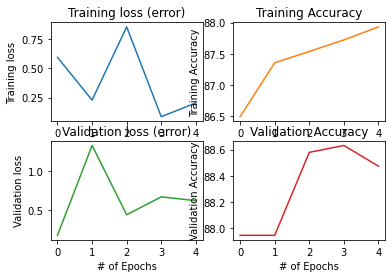

In [17]:
# learning_rate_list = [0.01, 0.001, 0.0001, 0.00001]
learning_rate_list = [0.01]
batch_size_list = [32, 64, 128, 256]
epoch_list = [20, 40, 60]

for i in learning_rate_list:
    #initialization model with def call 
    #model initialization
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
    model = torchvision.models.mobilenet_v2(pretrained=False)
    model.__init__
    gpumodel = model.cuda()
    print("model is ready!")
                
    schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

    #set hyperparameters
    run_type = "Test"
    learning_rate = i
    batch_size = 16
    epochs = 5


    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(gpumodel.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    model_name = f"hyperparam_opt_lr{learning_rate}_bs{batch_size}_ep{epochs}_project1_model"

    Train_loss_history = []
    Val_loss_history = []
    Train_accuracy_history = []
    Val_accuracy_history = []
    min_loss = 10

    print(f"running learning rate test: {i}")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_temp, train_accuracy_temp, min_loss, val_loss_temp, val_accuracy_temp = train_and_val_loop(part_train_loader, part_valid_loader, gpumodel, loss_fn, optimizer, model_name, min_loss)
        Train_loss_history.append(train_loss_temp.tolist())
        Train_accuracy_history.append(train_accuracy_temp.tolist())
        Val_loss_history.append(val_loss_temp.item()) 
        Val_accuracy_history.append(val_accuracy_temp.tolist())
        
    train_val_plot_save(learning_rate, batch_size, epochs, run_type)


In [163]:
# plotgraph(1, "Train", Train_loss_history, Train_accuracy_history)
# plotgraph(2, "Validation", Val_loss_history, Val_accuracy_history)
# plt.show()


def plotgraph():
    %matplotlib qt
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(Train_loss_history)
    axs[0, 0].set_title('Training loss (error)')
    axs[0, 0].set(xlabel='# of Epochs', ylabel='Training loss')
    axs[0, 1].plot(Train_accuracy_history, 'tab:orange')
    axs[0, 1].set_title('Training Accuracy')
    axs[0, 1].set(xlabel='# of Epochs', ylabel='Training Accuracy')
    axs[1, 0].plot(Val_loss_history, 'tab:green')
    axs[1, 0].set_title('Validation loss (error)')
    axs[1, 0].set(xlabel='# of Epochs', ylabel='Validation loss')
    axs[1, 1].plot(Val_accuracy_history, 'tab:red')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set(xlabel='# of Epochs', ylabel='Validation Accuracy')



    # def plotgraph(fig_number, type, type_lost_list, type_acc_list):
    # %matplotlib qt
    # plt.figure(fig_number)
    # plt.subplot(1, 2, 1)
    # plt.plot(type_lost_list)
    # plt.ylabel(f"{type} loss (error)")
    # plt.xlabel('# of epochs')
    # plt.title(f"{type}")
    # plt.subplot(1, 2, 2)
    # plt.plot(type_acc_list)
    # plt.ylabel(f"{type} accuracy")
    # plt.xlabel('# of epochs')
    # plt.title(f"{type}")
    # plt.show(block=False)

# plt.subplot(1, 2, 1)
# plt.plot(Val_loss_history)
# plt.ylabel('validation loss (error)')
# plt.xlabel('# of epochs')
# plt.title('validation')
# plt.subplot(1, 2, 2)
# plt.plot(Val_accuracy_history)
# plt.ylabel('validation accuracy')
# plt.xlabel('# of epochs')
# plt.title('validation')
# plt.figure(0)
# plt.figure(figsize=(2,2))
# plt.show()



In [165]:
# plotgraph(1, "Train", Train_loss_history, Train_accuracy_history)
# plotgraph(2, "Validation", Val_loss_history, Val_accuracy_history)
# plt.show()
plotgraph()

<font size="5">Final Run Training and Validaiton</font>



TO DO: 
- Set hyperparameters to values based on findings above

In [ ]:
learning_rate_list = [0.01, 0.001, 0.0001, 0.00001]
batch_size_list = [32, 64, 128, 256]
epoch_list = [20, 40, 60]


epochs = 5
learning_rate = 0.001

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
model_name = "project1_model"

Train_loss_history = []
Val_loss_history = []
Train_accuracy_history = []
Val_accuracy_history = []
min_loss = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_temp, train_accuracy_temp, min_loss, val_loss_temp, val_accuracy_temp = train_and_val_loop(train_loader, valid_loader, gpumodel, loss_fn, optimizer, model_name, min_loss)
    Train_loss_history.append(train_loss_temp.tolist())
    Train_accuracy_history.append(train_accuracy_temp.tolist())
    Val_loss_history.append(val_loss_temp)
    Val_accuracy_history.append(val_accuracy_temp.tolist())
    


Done!


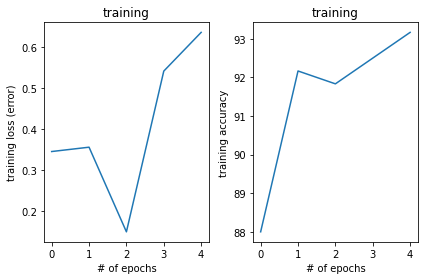

In [21]:
plt.subplot(1, 2, 1)
plt.plot(Train_loss_history)
plt.ylabel('training loss (error)')
plt.xlabel('# of epochs')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(Train_accuracy_history)
plt.ylabel('training accuracy')
plt.xlabel('# of epochs')
plt.title('training')
plt.figure(1)
plt.tight_layout()
    
print("Done!")

<font size="5">Plot Results</font>


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

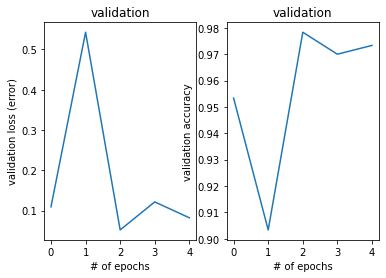

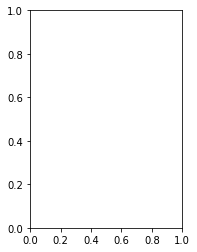

In [39]:
plt.subplot(1, 2, 1)
plt.plot(Val_loss_history)
plt.ylabel('validation loss (error)')
plt.xlabel('# of epochs')
plt.title('validation')

plt.subplot(1, 2, 2)
plt.plot(Val_accuracy_history)
plt.ylabel('validation accuracy')
plt.xlabel('# of epochs')
plt.title('validation')
plt.figure(0)
plt.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(Train_loss_history)
plt.ylabel('training loss (error)')
plt.xlabel('# of epochs')
plt.title('training')
plt.subplot(1, 2, 2)
plt.plot(Train_accuracy_history)
plt.ylabel('training accuracy')
plt.xlabel('# of epochs')
plt.title('training')
plt.figure(1)
plt.tight_layout()

<font size="5">Run Testing/Confusion Matrix</font>



TO DO: 
- Add heat mapping to the following

In [66]:
test_loop(test_loader, model, loss_fn, optimizer, model_name)

100%|██████████| 75/75 [00:45<00:00,  1.65it/s]

 Test Accuracy: 84.33332824707031
[[171   2   6  21]
 [ 13  77   8   2]
 [  1   3 191   5]
 [ 13   4  16  67]]


<font size="5">Experimental Code</font>



In [46]:
epochs = 3
val_loss_min = np.Inf
model_name = 'ExoNet_Project1.pt'

Train_loss_history = []
Val_loss_history = []
Train_accuracy_history = []
Val_accuracy_history = []


for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    
    model.train()
    for images,labels,fnames in tqdm(train_loader):
        optimizer.zero_grad()

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy(preds, labels)
        
   

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    model.eval()
    with torch.no_grad():
        for images,labels,fnames in tqdm(valid_loader):

            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            val_acc += accuracy(preds, labels)
            
         
        
        avg_val_loss = val_loss / len(valid_loader)
        avg_val_acc = val_acc / len(valid_loader)

    schedular.step(avg_val_loss)
    
    torch.sum(preds == labels)
    Train_loss_history.append([train_loss])
    Train_accuracy_history.append([train_acc])
    Val_loss_history.append([val_loss])
    Val_accuracy_history.append([val_acc])

    print("Epoch : {} \ntrain_loss : {:.6f}, \tTrain_acc : {:.6f}, \nVal_loss : {:.6f}, \tVal_acc : {:.6f}".format(epoch + 1,
                                                                                                                   avg_train_loss, avg_train_acc,
                                                                                                                   avg_val_loss, avg_val_acc))
    if avg_val_loss <= val_loss_min:
        print('Validation loss decreased from ({:.6f} --> {:.6f}).\nSaving model ...'.format(val_loss_min, avg_val_loss))
        torch.save(model.state_dict(), model_name)
        val_loss_min = avg_val_loss
    
    print(train_acc)
    print(val_acc)
    Train_loss_history.append([train_loss])
    Train_accuracy_history.append([train_acc])
    Val_loss_history.append([val_loss])
    Val_accuracy_history.append([val_acc])  
    
        
print("training finished!")

  0%|          | 0/38 [00:01<?, ?it/s]


RuntimeError: Expected floating point type for target with class probabilities, got Long

Plot results for training and validation

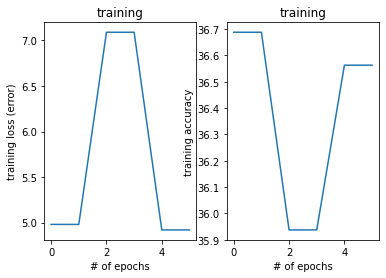

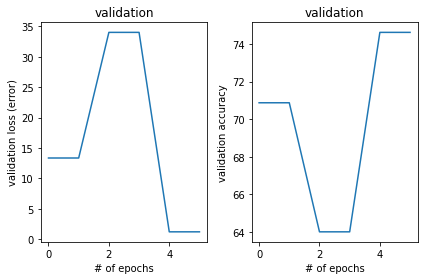

In [33]:
plt.subplot(1, 2, 1)
plt.plot(Val_loss_history)
plt.ylabel('validation loss (error)')
plt.xlabel('# of epochs')
plt.title('validation')

plt.subplot(1, 2, 2)
plt.plot(Val_accuracy_history)
plt.ylabel('validation accuracy')
plt.xlabel('# of epochs')
plt.title('validation')
plt.figure(0)
plt.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(Train_loss_history)
plt.ylabel('training loss (error)')
plt.xlabel('# of epochs')
plt.title('training')
plt.subplot(1, 2, 2)
plt.plot(Train_accuracy_history)
plt.ylabel('training accuracy')
plt.xlabel('# of epochs')
plt.title('training')
plt.figure(1)
plt.tight_layout()

In [1]:
epochs = 15
val_loss_min = np.Inf
model_name = 'ExoNet_Project1.pt'

Train_loss_history = []
Val_loss_history = []
Train_accuracy_history = []
Val_accuracy_history = []


for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    
    model.train()
    for images,labels,fnames in tqdm(train_loader):
        optimizer.zero_grad()

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(preds, labels)
        
    Train_loss_history.append([epoch, train_loss])
    Train_accuracy_history.append([epoch, train_acc])

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    model.eval()
    with torch.no_grad():
        for images,labels,fnames in tqdm(valid_loader):

            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            val_acc += accuracy(preds, labels)
            
        Val_loss_history.append([epoch, val_loss])
        Val_accuracy_history.append([epoch, val_acc]) 
        
        avg_val_loss = val_loss / len(valid_loader)
        avg_val_acc = val_acc / len(valid_loader)

    schedular.step(avg_val_loss)

    print("Epoch : {} \ntrain_loss : {:.6f}, \tTrain_acc : {:.6f}, \nVal_loss : {:.6f}, \tVal_acc : {:.6f}".format(epoch + 1,
                                                                                                                   avg_train_loss, avg_train_acc,
                                                                                                                   avg_val_loss, avg_val_acc))
    if avg_val_loss <= val_loss_min:
        print('Validation loss decreased from ({:.6f} --> {:.6f}).\nSaving model ...'.format(val_loss_min, avg_val_loss))
        torch.save(model.state_dict(), model_name)
        val_loss_min = avg_val_loss
    

Python 3.6.9 :: Anaconda, Inc.
